### Import libraries and create DataFrame from csv 

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("FantasyPros_Fantasy_Football_Statistics_RB.csv")

df.head(10)

,Rank,Player,ATT,YDS,Y/A,LG,20+,TD,REC,TGT,YDS.1,Y/R,TD.1,FL,G,FPTS,FPTS/G,ROST
0,1.0,Austin Ekeler (LAC),204.0,915,4.5,72.0,10.0,13.0,107.0,127.0,722.0,6.7,5.0,3.0,17.0,372.7,21.9,100.0%
1,2.0,Christian McCaffrey (SF),244.0,"1,139",4.7,49.0,14.0,8.0,85.0,108.0,741.0,8.7,5.0,0.0,17.0,356.4,21.0,100.0%
2,3.0,Josh Jacobs (LV),340.0,"1,653",4.9,86.0,14.0,12.0,53.0,64.0,400.0,7.5,0.0,1.0,17.0,328.3,19.3,99.8%
3,4.0,Derrick Henry (TEN),349.0,"1,538",4.4,56.0,20.0,13.0,33.0,41.0,398.0,12.1,0.0,3.0,16.0,302.8,18.9,99.9%
4,5.0,Saquon Barkley (NYG),295.0,"1,312",4.4,68.0,16.0,10.0,57.0,76.0,338.0,5.9,0.0,0.0,16.0,284.0,17.8,100.0%
5,6.0,Nick Chubb (CLE),302.0,"1,525",5.0,41.0,18.0,12.0,27.0,37.0,239.0,8.9,1.0,1.0,17.0,281.4,16.6,25.6%
6,7.0,Rhamondre Stevenson (NE),210.0,"1,040",5.0,49.0,12.0,5.0,69.0,88.0,421.0,6.1,1.0,1.0,17.0,249.1,14.7,96.1%
7,8.0,Tony Pollard (DAL),193.0,"1,007",5.2,57.0,18.0,9.0,39.0,55.0,371.0,9.5,3.0,0.0,16.0,248.8,15.6,99.8%
8,9.0,Aaron Jones (GB),213.0,"1,121",5.3,36.0,10.0,2.0,59.0,72.0,395.0,6.7,5.0,3.0,17.0,248.6,14.6,97.5%
9,10.0,Joe Mixon (CIN),212.0,826,3.9,40.0,7.0,7.0,60.0,75.0,441.0,7.4,2.0,0.0,15.0,240.7,16.0,98.4%


### Remove irrelevant columns and define column numbers

In [191]:
df.drop(['FL', 'ROST'], axis=1, inplace=True)

# Enumerate the columns to view their positions (numbers) and names
list(enumerate(df.columns))

[(0, 'Rank'),
 (1, 'Player'),
 (2, 'ATT'),
 (3, 'YDS'),
 (4, 'Y/A'),
 (5, 'LG'),
 (6, '20+'),
 (7, 'TD'),
 (8, 'REC'),
 (9, 'TGT'),
 (10, 'YDS.1'),
 (11, 'Y/R'),
 (12, 'TD.1'),
 (13, 'G'),
 (14, 'FPTS'),
 (15, 'FPTS/G')]

### Check the data types of the columns

In [192]:
df.dtypes

Rank      float64
Player     object
ATT       float64
YDS        object
Y/A       float64
LG        float64
20+       float64
TD        float64
REC       float64
TGT       float64
YDS.1     float64
Y/R       float64
TD.1      float64
G         float64
FPTS      float64
FPTS/G    float64
dtype: object

### Convert columns with an 'object' data type to a 'float' data type

In [193]:
# Convert columns with object data type, excluding certain columns
convert = df.select_dtypes('object').columns.difference(['Player'])
df[convert] = df[convert].apply(lambda x: pd.to_numeric(x.str.replace(',', ''), errors='coerce')).fillna(0)

# Convert specific columns to desired data types
df['Rank'] = df['Rank'].astype('Int64')

# Verify the data types
df.dtypes

Rank        Int64
Player     object
ATT       float64
YDS       float64
Y/A       float64
LG        float64
20+       float64
TD        float64
REC       float64
TGT       float64
YDS.1     float64
Y/R       float64
TD.1      float64
G         float64
FPTS      float64
FPTS/G    float64
dtype: object

### Verify data conversion is correct

In [194]:
df.head(10)

,Rank,Player,ATT,YDS,Y/A,LG,20+,TD,REC,TGT,YDS.1,Y/R,TD.1,G,FPTS,FPTS/G
0,1,Austin Ekeler (LAC),204.0,915.0,4.5,72.0,10.0,13.0,107.0,127.0,722.0,6.7,5.0,17.0,372.7,21.9
1,2,Christian McCaffrey (SF),244.0,1139.0,4.7,49.0,14.0,8.0,85.0,108.0,741.0,8.7,5.0,17.0,356.4,21.0
2,3,Josh Jacobs (LV),340.0,1653.0,4.9,86.0,14.0,12.0,53.0,64.0,400.0,7.5,0.0,17.0,328.3,19.3
3,4,Derrick Henry (TEN),349.0,1538.0,4.4,56.0,20.0,13.0,33.0,41.0,398.0,12.1,0.0,16.0,302.8,18.9
4,5,Saquon Barkley (NYG),295.0,1312.0,4.4,68.0,16.0,10.0,57.0,76.0,338.0,5.9,0.0,16.0,284.0,17.8
5,6,Nick Chubb (CLE),302.0,1525.0,5.0,41.0,18.0,12.0,27.0,37.0,239.0,8.9,1.0,17.0,281.4,16.6
6,7,Rhamondre Stevenson (NE),210.0,1040.0,5.0,49.0,12.0,5.0,69.0,88.0,421.0,6.1,1.0,17.0,249.1,14.7
7,8,Tony Pollard (DAL),193.0,1007.0,5.2,57.0,18.0,9.0,39.0,55.0,371.0,9.5,3.0,16.0,248.8,15.6
8,9,Aaron Jones (GB),213.0,1121.0,5.3,36.0,10.0,2.0,59.0,72.0,395.0,6.7,5.0,17.0,248.6,14.6
9,10,Joe Mixon (CIN),212.0,826.0,3.9,40.0,7.0,7.0,60.0,75.0,441.0,7.4,2.0,15.0,240.7,16.0


### Convert relevant stats to a per-game basis and create the final stats for analysis

In [195]:
# Define columns for per-game calculation
per_game = list(df.columns[2:])

# Define columns to exclude from the per-game calculation
exclude_per_game = ['Y/A', 'LG', 'Y/R', 'G', 'FPTS', 'FPTS/G']

# Create columns and convert stats to a per-game basis for the defined columns, not those in the exclude list
for col in per_game:
    if col not in exclude_per_game:
        df[col + '/game'] = (df[col] / df['G']).round(1)

# Define final columns to be used for analysis, combines excluded and new per-game columns
final_columns = exclude_per_game + [col + '/game' for col in per_game if col not in exclude_per_game]

# Display final columns with 'Rank' and 'Player'
df[['Rank', 'Player'] + final_columns].head(10)

,Rank,Player,Y/A,LG,Y/R,G,FPTS,FPTS/G,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
0,1,Austin Ekeler (LAC),4.5,72.0,6.7,17.0,372.7,21.9,12.0,53.8,0.6,0.8,6.3,7.5,42.5,0.3
1,2,Christian McCaffrey (SF),4.7,49.0,8.7,17.0,356.4,21.0,14.4,67.0,0.8,0.5,5.0,6.4,43.6,0.3
2,3,Josh Jacobs (LV),4.9,86.0,7.5,17.0,328.3,19.3,20.0,97.2,0.8,0.7,3.1,3.8,23.5,0.0
3,4,Derrick Henry (TEN),4.4,56.0,12.1,16.0,302.8,18.9,21.8,96.1,1.2,0.8,2.1,2.6,24.9,0.0
4,5,Saquon Barkley (NYG),4.4,68.0,5.9,16.0,284.0,17.8,18.4,82.0,1.0,0.6,3.6,4.8,21.1,0.0
5,6,Nick Chubb (CLE),5.0,41.0,8.9,17.0,281.4,16.6,17.8,89.7,1.1,0.7,1.6,2.2,14.1,0.1
6,7,Rhamondre Stevenson (NE),5.0,49.0,6.1,17.0,249.1,14.7,12.4,61.2,0.7,0.3,4.1,5.2,24.8,0.1
7,8,Tony Pollard (DAL),5.2,57.0,9.5,16.0,248.8,15.6,12.1,62.9,1.1,0.6,2.4,3.4,23.2,0.2
8,9,Aaron Jones (GB),5.3,36.0,6.7,17.0,248.6,14.6,12.5,65.9,0.6,0.1,3.5,4.2,23.2,0.3
9,10,Joe Mixon (CIN),3.9,40.0,7.4,15.0,240.7,16.0,14.1,55.1,0.5,0.5,4.0,5.0,29.4,0.1


### Calculate the correlations for the final stats across different conditions

In [196]:
# Define columns and columns to exclude for correlation calculation, from final columns
exclude_corr = ['FPTS/G', 'FPTS', 'G']
corr_columns = [col for col in final_columns if col not in exclude_corr]

# Define a function to calculate correlations
def compute_correlations(dataframe, corr_columns):
    return dataframe[corr_columns].corrwith(dataframe['FPTS/G'])

# Compute correlations for various conditions
corr_all = compute_correlations(df, corr_columns)
corr_nonzero = compute_correlations(df[df['FPTS/G'] > 0], corr_columns)
corr_top50 = compute_correlations(df[df['Rank'] <= 50], corr_columns)
corr_top25 = compute_correlations(df[df['Rank'] <= 25], corr_columns)

# Compile all correlations into a DataFrame for comparison
df_corr = pd.DataFrame({
    'All Players': corr_all,
    'FPTS > 0': corr_nonzero,
    'Top 50 Players': corr_top50,
    'Top 25 Players': corr_top25
})

# Calculate the average correlation across the four conditions, adding 'Average' column to DataFrame
df_corr['Correlation'] = df_corr.mean(axis=1)

df_corr.round(2)

,All Players,FPTS > 0,Top 50 Players,Top 25 Players,Correlation
Y/A,0.48,0.34,0.15,0.12,0.27
LG,0.79,0.75,0.44,0.38,0.59
Y/R,0.31,0.19,0.21,0.21,0.23
ATT/game,0.90,0.88,0.66,0.47,0.72
YDS/game,0.90,0.88,0.69,0.50,0.74
20+/game,0.75,0.73,0.47,0.36,0.58
TD/game,0.83,0.81,0.65,0.48,0.69
REC/game,0.82,0.79,0.67,0.59,0.72
TGT/game,0.82,0.80,0.67,0.58,0.72
YDS.1/game,0.81,0.79,0.69,0.60,0.72


### Assign the weights for the final stats

In [197]:
# Calculate R^2 for the 'Average' correlation, adding 'R^2' column to DataFrame
df_corr['R^2'] = df_corr['Correlation'] ** 2

# Define the calculation to assign weights
def weight_calc(row):
    if row['Correlation'] >= 0.69:
        return 1 + row['R^2']
    else:
        return 1
    
# Assign weights based on the given criteria, adding 'Weight' column to DataFrame
df_corr['Weight'] = df_corr.apply(weight_calc, axis=1)

# Display the new columns in the DataFrame
df_corr[['Correlation', 'R^2', 'Weight']].round(2)

,Correlation,R^2,Weight
Y/A,0.27,0.07,1.00
LG,0.59,0.35,1.00
Y/R,0.23,0.05,1.00
ATT/game,0.72,0.53,1.53
YDS/game,0.74,0.55,1.55
20+/game,0.58,0.33,1.00
TD/game,0.69,0.48,1.48
REC/game,0.72,0.52,1.52
TGT/game,0.72,0.52,1.52
YDS.1/game,0.72,0.52,1.52


### Multiply the assigned weights to the final stats

In [198]:
# Multiply each relevant column by its corresponding weight
for col in corr_columns:
    weight = df_corr.loc[col, 'Weight']
    df[col + '_weighted'] = (df[col] * weight).round(1)

# Extract the weighted columns
weight_columns = [col + '_weighted' for col in corr_columns]

# Display the new weighted stats columns
df[['Rank', 'Player', 'FPTS/G'] + weight_columns].head(10)

,Rank,Player,FPTS/G,Y/A_weighted,LG_weighted,Y/R_weighted,ATT/game_weighted,YDS/game_weighted,20+/game_weighted,TD/game_weighted,REC/game_weighted,TGT/game_weighted,YDS.1/game_weighted,TD.1/game_weighted
0,1,Austin Ekeler (LAC),21.9,4.5,72.0,6.7,18.3,83.4,0.6,1.2,9.6,11.4,64.7,0.3
1,2,Christian McCaffrey (SF),21.0,4.7,49.0,8.7,22.0,103.8,0.8,0.7,7.6,9.7,66.4,0.3
2,3,Josh Jacobs (LV),19.3,4.9,86.0,7.5,30.5,150.6,0.8,1.0,4.7,5.8,35.8,0.0
3,4,Derrick Henry (TEN),18.9,4.4,56.0,12.1,33.2,148.9,1.2,1.2,3.2,3.9,37.9,0.0
4,5,Saquon Barkley (NYG),17.8,4.4,68.0,5.9,28.1,127.0,1.0,0.9,5.5,7.3,32.1,0.0
5,6,Nick Chubb (CLE),16.6,5.0,41.0,8.9,27.1,139.0,1.1,1.0,2.4,3.3,21.5,0.1
6,7,Rhamondre Stevenson (NE),14.7,5.0,49.0,6.1,18.9,94.8,0.7,0.4,6.2,7.9,37.8,0.1
7,8,Tony Pollard (DAL),15.6,5.2,57.0,9.5,18.5,97.5,1.1,0.9,3.6,5.2,35.3,0.2
8,9,Aaron Jones (GB),14.6,5.3,36.0,6.7,19.1,102.1,0.6,0.1,5.3,6.4,35.3,0.3
9,10,Joe Mixon (CIN),16.0,3.9,40.0,7.4,21.5,85.4,0.5,0.7,6.1,7.6,44.8,0.1


### Display the columns potentially to be included in the average weighted score

In [199]:
high_corr = df_corr[df_corr['Correlation'] >= 0.69].index.tolist()
conditional_columns = [col + '_weighted' for col in high_corr if col + '_weighted' in df.columns]

# Include 'FPTS/G' in columns to be used for the average weighted score
conditional_columns.append('FPTS/G')

conditional_columns

['ATT/game_weighted',
 'YDS/game_weighted',
 'TD/game_weighted',
 'REC/game_weighted',
 'TGT/game_weighted',
 'YDS.1/game_weighted',
 'FPTS/G']

### Define the columns to be used for the average weighted score

In [200]:
# Define select columns to be used for the average weighted score
avg = ['ATT/game_weighted',
 'YDS/game_weighted',
 'TD/game_weighted',
 'REC/game_weighted',
 'TGT/game_weighted',
 'YDS.1/game_weighted',
 'FPTS/G']

### Calculate each player's average weighted score and rank them from high to low

In [201]:
# Calculate the average weighted score for the select columns
df['Score'] = df[avg].mean(axis=1).round(1)

# Rank both of the average weighted scores with NaN handling
df['Final Rank'] = df.sort_values('Score', ascending=False)\
                ['Score'].rank(method='first', ascending=False, na_option='bottom').astype(int)

# Calculate the variance in ranking both ranks
df['Variance'] = df['Rank'] - df['Final Rank']

### Display results of the average weighted score and rank

In [202]:
# Display the results for the select columns
analysis = df[['Rank', 'Final Rank', 'Player', 'Score', 'Variance']]
analysis.set_index('Rank', inplace=True)
analysis.sort_values(by='Final Rank', ascending=True).head(30)

,Final Rank,Player,Score,Variance
Rank,,,,
3,1,Josh Jacobs (LV),35.4,2
4,2,Derrick Henry (TEN),35.3,2
2,3,Christian McCaffrey (SF),33.0,-1
5,4,Saquon Barkley (NYG),31.2,1
1,5,Austin Ekeler (LAC),30.1,-4
6,6,Nick Chubb (CLE),30.1,0
42,7,Breece Hall (NYJ),27.9,35
16,8,Alvin Kamara (NO),27.6,8
9,9,Aaron Jones (GB),26.1,0


### Compare per-game stats of two players and visualize the results

In [203]:
# Type in or copy & paste (from 'Player' column) the names of the players to compare
player1 = 'Christian McCaffrey (SF)' # <-- Player 1 name here
player2 = 'Austin Ekeler (LAC)' # <-- Player 2 name here

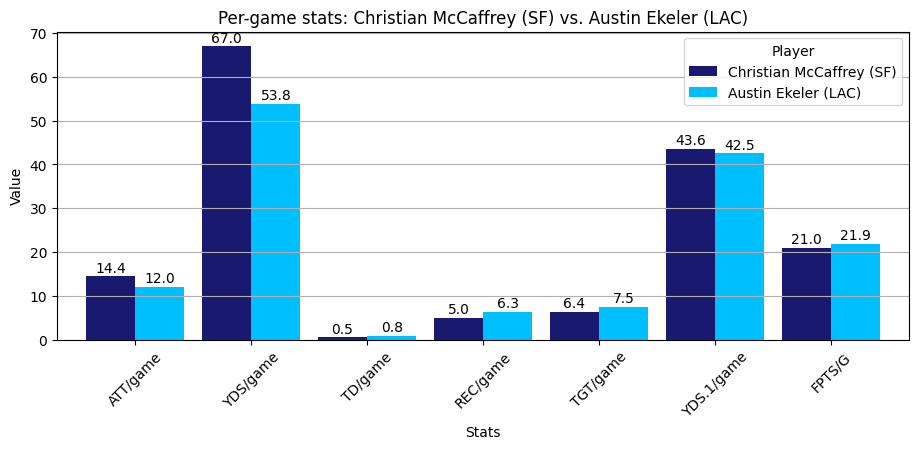

,Final Rank,Y/A,LG,Y/R,G,FPTS,FPTS/G,ATT/game,YDS/game,20+/game,TD/game,REC/game,TGT/game,YDS.1/game,TD.1/game
Player,,,,,,,,,,,,,,,
Christian McCaffrey (SF),3,4.7,49.0,8.7,17.0,356.4,21.0,14.4,67.0,0.8,0.5,5.0,6.4,43.6,0.3
Austin Ekeler (LAC),5,4.5,72.0,6.7,17.0,372.7,21.9,12.0,53.8,0.6,0.8,6.3,7.5,42.5,0.3


In [204]:
# Extract and reorder rows for the two specified players
players = df[df['Player'].isin([player1, player2])]
players.set_index('Player', inplace=True)
players = players.reindex([player1, player2])

# Define columns to be compared
compare_columns = [col.replace('_weighted', '') for col in avg]

# Define a function to compare per-game stats of two players
def compare(player1, player2):

    # Plot the data
    chart = players[compare_columns].T.plot(kind='bar',
                                            color=['midnightblue', 'deepskyblue'],
                                            width=0.85,
                                            figsize=(11,4))

    # Format chart
    plt.title(f'Per-game stats: {player1} vs. {player2}')
    plt.xlabel('Stats')
    plt.ylabel('Value')
    plt.grid(axis='y')
    plt.xticks(rotation=45)

    # Add data labels above the bars
    for p in chart.patches:
        chart.annotate(f'{p.get_height():.1f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 6), 
                    textcoords = 'offset points')

    plt.show()

# Call the 'compare' function which creates and displays the visualization
compare(player1, player2)
players[['Final Rank'] + final_columns]